<a href="https://colab.research.google.com/github/knickka/Malaria/blob/main/Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Datas

In [1]:
# IMPORTING DEPENDENCIES
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds


In [2]:
dataset, dataset_info = tfds.load(name = 'malaria', shuffle_files = True, as_supervised = True, split= 'train',with_info = True ) # downloading data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete8FOZ1I/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [29]:
len(dataset)

27558

In [30]:
#function to split the dataset into train,validation and test sets
def splits(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
  DATASET_SIZE =  len(dataset)


  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = (dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))).take(int(VAL_RATIO*DATASET_SIZE))
  test_dataset = (dataset.skip(int((TRAIN_RATIO+VAL_RATIO)*DATASET_SIZE))).take(int(TEST_RATIO*DATASET_SIZE))

  return train_dataset,val_dataset,test_dataset


In [31]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset,val_dataset,test_dataset = splits(dataset, TRAIN_RATIO,VAL_RATIO,TEST_RATIO)

print(train_dataset,val_dataset,test_dataset)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))> <_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))> <_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [32]:
len(test_dataset)

2755

In [33]:
dataset_info.features['label']

ClassLabel(shape=(), dtype=int64, num_classes=2)

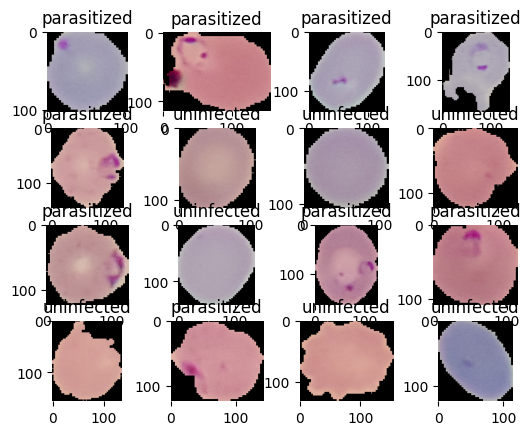

In [34]:
for i, (image,label)in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1,frameon=False)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))



## DATA PREPROCESS

In [35]:
#resizing the image to 224x224 and rescaling the the pixel values form (0-225) to (0-1)
IM_SIZE = 224
def resize_rescale(image,label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0, label

In [36]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [37]:
for image,label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [38]:
train_dataset = train_dataset.shuffle(buffer_size = 8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

## MODEL

In [47]:

lenet_model = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),
                             tf.keras.layers.Conv2D(filters=6, kernel_size = 3, strides = 1,padding = 'valid', activation = 'relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPooling2D(pool_size =2, strides = 2),
                             tf.keras.layers.Conv2D(filters=16, kernel_size = 3, strides = 1,padding = 'valid', activation = 'relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPooling2D(pool_size =2, strides = 2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(100,activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dense(10,activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dense(1,activation='sigmoid')])

In [48]:
lenet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

In [51]:
lenet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = 'accuracy')

In [52]:
lenet_history = lenet_model.fit(train_dataset,validation_data = val_dataset, epochs = 100,verbose=1)

Epoch 1/100
689/689 [==============================] - 53s 70ms/step - loss: 0.2334 - accuracy: 0.9249 - val_loss: 0.2853 - val_accuracy: 0.9154
Epoch 2/100
689/689 [==============================] - 57s 82ms/step - loss: 0.2093 - accuracy: 0.9290 - val_loss: 0.3419 - val_accuracy: 0.9103
Epoch 3/100
689/689 [==============================] - 57s 82ms/step - loss: 0.2013 - accuracy: 0.9345 - val_loss: 0.3162 - val_accuracy: 0.9151
Epoch 4/100
689/689 [==============================] - 50s 73ms/step - loss: 0.1864 - accuracy: 0.9408 - val_loss: 0.2695 - val_accuracy: 0.9042
Epoch 5/100
689/689 [==============================] - 55s 80ms/step - loss: 0.1769 - accuracy: 0.9430 - val_loss: 0.3509 - val_accuracy: 0.8973
Epoch 6/100
689/689 [==============================] - 48s 70ms/step - loss: 0.1644 - accuracy: 0.9461 - val_loss: 0.1785 - val_accuracy: 0.9412
Epoch 7/100
689/689 [==============================] - 50s 72ms/step - loss: 0.2090 - accuracy: 0.9287 - val_loss: 1.8849 - val_ac

In [54]:
test_dataset = test_dataset.batch(1)

In [55]:
lenet_model.evaluate(test_dataset)

2755/2755 [==============================] - 23s 4ms/step - loss: 0.4520 - accuracy: 0.9426


[0.45197802782058716, 0.9426497220993042]

In [57]:
lenet_model.save(filepath='/content/drive/MyDrive/Colab Notebooks/Malaria/lenet_model',save_format="tf")